In [1]:
import pandas as pd
import numpy as np
import prepare
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy.stats as stats
from sklearn.model_selection import train_test_split


# modeling methods
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")

In [2]:
from acquire import get_zillow_data

In [3]:
# acquire the zillow dataset that we are using
df = get_zillow_data()
df.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,yearbuilt,taxvaluedollarcnt,taxamount,propertylandusetypeid
0,11721753,2.0,3.0,1316.0,6037.0,1923.0,205123.0,2627.48,261.0
1,11289917,2.0,3.0,1458.0,6037.0,1970.0,136104.0,2319.90,261.0
2,11705026,1.0,2.0,1421.0,6037.0,1911.0,35606.0,543.69,261.0
3,14269464,3.0,4.0,2541.0,6059.0,2003.0,880456.0,9819.72,261.0
4,11446756,2.0,3.0,1491.0,6037.0,1955.0,107110.0,1399.27,261.0


In [4]:
df.shape

(28186, 9)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25648 entries, 0 to 28184
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   parcelid               25648 non-null  int64  
 1   bath                   25648 non-null  float64
 2   bed                    25648 non-null  float64
 3   sqrft                  25648 non-null  float64
 4   county                 25648 non-null  float64
 5   yearbuilt              25648 non-null  float64
 6   taxval                 25648 non-null  float64
 7   taxamt                 25648 non-null  float64
 8   propertylandusetypeid  25648 non-null  float64
 9   tax_rate               25648 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 2.2 MB


## PREPARE

In [7]:
#check for null values
df.isnull().sum()

parcelid                         0
bathroomcnt                      0
bedroomcnt                       0
calculatedfinishedsquarefeet    68
fips                             0
yearbuilt                       92
taxvaluedollarcnt                1
taxamount                        1
propertylandusetypeid            0
dtype: int64

In [8]:
#drop nulls
df = df.dropna()

In [9]:
#verify nulls were dropped
df.isnull().sum()

parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
yearbuilt                       0
taxvaluedollarcnt               0
taxamount                       0
propertylandusetypeid           0
dtype: int64

In [11]:
df['parcelid'].duplicated().value_counts()

False    28065
True        24
Name: parcelid, dtype: int64

In [12]:
df.drop_duplicates(subset = ['parcelid'], inplace=True)

In [13]:
df['parcelid'].duplicated().value_counts()

False    28065
Name: parcelid, dtype: int64

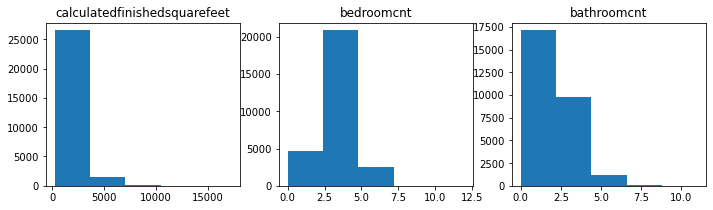

In [14]:
# Plot the distributions
plt.figure(figsize=(16, 3))

# List of columns
cols = ['calculatedfinishedsquarefeet', 'bedroomcnt', 'bathroomcnt']

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1,4, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)

#### You will need to figure out which field gives you the annual tax amount for the property in order to calculate the tax rate. Using the property's assessed value (taxvaluedollarcnt) and the amount they pay each year (<field name>) to compute tax rate.

In [15]:
df['tax_rate'] =df['taxamount']/  df['taxvaluedollarcnt']

#### You will want to do some data validation or QA (quality assurance) to be sure the data you gather is what you think it is.



In [16]:
df.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,yearbuilt,taxvaluedollarcnt,taxamount,propertylandusetypeid,tax_rate
0,11721753,2.0,3.0,1316.0,6037.0,1923.0,205123.0,2627.48,261.0,0.012809
1,11289917,2.0,3.0,1458.0,6037.0,1970.0,136104.0,2319.90,261.0,0.017045
2,11705026,1.0,2.0,1421.0,6037.0,1911.0,35606.0,543.69,261.0,0.015270
3,14269464,3.0,4.0,2541.0,6059.0,2003.0,880456.0,9819.72,261.0,0.011153
4,11446756,2.0,3.0,1491.0,6037.0,1955.0,107110.0,1399.27,261.0,0.013064


In [17]:
df.rename(columns={'bathroomcnt': 'bath', 
                     'bedroomcnt': 'bed',
                     'calculatedfinishedsquarefeet': 'sqrft',
                     'fips': 'county',
                     'taxvaluedollarcnt': 'taxval',
                     'taxamount': 'taxamt'}, inplace=True
            )

In [18]:
df.head(3)

,parcelid,bath,bed,sqrft,county,yearbuilt,taxval,taxamt,propertylandusetypeid,tax_rate
0,11721753,2.0,3.0,1316.0,6037.0,1923.0,205123.0,2627.48,261.0,0.012809
1,11289917,2.0,3.0,1458.0,6037.0,1970.0,136104.0,2319.90,261.0,0.017045
2,11705026,1.0,2.0,1421.0,6037.0,1911.0,35606.0,543.69,261.0,0.015270


In [19]:
df['propertylandusetypeid'].value_counts()

261.0    28026
263.0       28
260.0        8
264.0        3
Name: propertylandusetypeid, dtype: int64

In [20]:
## we would use this if we are going to use minmaxscaler
## prepare.outlier_bound_calculation(df, bathroomcnt)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28065 entries, 0 to 28184
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   parcelid               28065 non-null  int64  
 1   bath                   28065 non-null  float64
 2   bed                    28065 non-null  float64
 3   sqrft                  28065 non-null  float64
 4   county                 28065 non-null  float64
 5   yearbuilt              28065 non-null  float64
 6   taxval                 28065 non-null  float64
 7   taxamt                 28065 non-null  float64
 8   propertylandusetypeid  28065 non-null  float64
 9   tax_rate               28065 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 2.4 MB


In [22]:
def outlier_bound_calculation(df, variable):
    '''
    calcualtes the lower and upper bound to locate outliers in variables
    '''
    quartile1, quartile3 = np.percentile(df[variable], [25,75])
    IQR_value = quartile3 - quartile1
    lower_bound = quartile1 - (1.5 * IQR_value)
    upper_bound = quartile3 + (1.5 * IQR_value)
    '''
    returns the lowerbound and upperbound values
    '''
    return print(f'For {variable} the lower bound is {lower_bound} and  upper bound is {upper_bound}')

In [23]:
outlier_bound_calculation(df, 'bath')

For bath the lower bound is 0.5 and  upper bound is 4.5


In [24]:
df= df[df.bath > 0.5]
df= df[df.bath < 4.5]

In [25]:
outlier_bound_calculation(df, 'bed')

For bed the lower bound is 1.5 and  upper bound is 5.5


In [26]:
df= df[df.bed > 1.5]
df= df[df.bed < 5.5]

In [27]:
outlier_bound_calculation(df, 'sqrft')

For sqrft the lower bound is -118.0 and  upper bound is 3586.0


In [28]:
df= df[df.sqrft > -118.0]
df= df[df.sqrft < 3586.0]

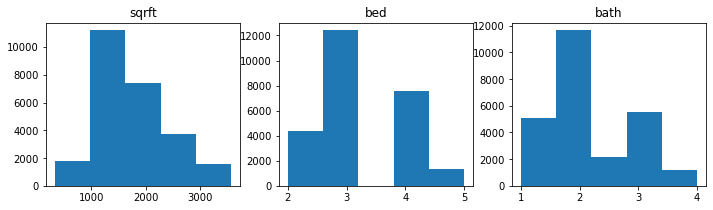

In [29]:
# Plot the distributions
plt.figure(figsize=(16, 3))

# List of columns
cols = ['sqrft', 'bed', 'bath']

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1,4, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)

In [40]:
# Scale everything else through MinMax

In [35]:
def split_continuous(df):
    '''
    Takes in a df
    Returns train, validate, and test DataFrames
    '''
    # Create train_validate and test datasets
    train_validate, test = train_test_split(df, 
                                        test_size=.2, 
                                        random_state=123)
    # Create train and validate datsets
    train, validate = train_test_split(train_validate, 
                                   test_size=.3, 
                                   random_state=123)
    return train, validate, test

In [36]:
# split the data in train, validate and test
train, test = train_test_split(df, test_size = 0.2, random_state = 1349)
train, validate = train_test_split(train, test_size = 0.25, random_state = 1349)

In [37]:
#check the shape
train.shape, validate.shape, test.shape

((15388, 10), (5130, 10), (5130, 10))

In [38]:
train.head()

,parcelid,bath,bed,sqrft,county,yearbuilt,taxval,taxamt,propertylandusetypeid,tax_rate
5959,11324084,3.0,3.0,2544.0,6037.0,2005.0,228849.0,5519.18,261.0,0.024117
21006,12797236,1.0,3.0,1176.0,6037.0,1952.0,215183.0,2818.59,261.0,0.013099
14071,12319787,2.0,3.0,1690.0,6037.0,1975.0,100911.0,1426.08,261.0,0.014132
23145,11682794,3.0,3.0,3006.0,6037.0,1974.0,6523866.0,74726.31,261.0,0.011454
16963,12272985,1.0,2.0,634.0,6037.0,1949.0,30371.0,933.69,261.0,0.030743


### Explore

In [ ]:
# a lot of these functions already came from the prepare.py file kbest, rfe

In [39]:
df_corr = train.drop(columns=['parcelid', 'propertylandusetypeid'])
df_corr

,bath,bed,sqrft,county,yearbuilt,taxval,taxamt,tax_rate
5959,3.0,3.0,2544.0,6037.0,2005.0,228849.0,5519.18,0.024117
21006,1.0,3.0,1176.0,6037.0,1952.0,215183.0,2818.59,0.013099
14071,2.0,3.0,1690.0,6037.0,1975.0,100911.0,1426.08,0.014132
23145,3.0,3.0,3006.0,6037.0,1974.0,6523866.0,74726.31,0.011454
16963,1.0,2.0,634.0,6037.0,1949.0,30371.0,933.69,0.030743
...,...,...,...,...,...,...,...,...
27776,2.0,2.0,1411.0,6037.0,1962.0,580623.0,7176.89,0.012361
4813,2.5,5.0,2536.0,6059.0,1975.0,354581.0,3936.38,0.011101
25688,1.0,3.0,972.0,6037.0,1952.0,425000.0,5114.59,0.012034
995,1.0,3.0,1012.0,6037.0,1944.0,253162.0,3178.72,0.012556


In [41]:
# statistical testing

In [42]:
# key drivers - MVP

In [43]:
# prove mvp is correlated to price

In [44]:
# start running models - Linear regression, polynomial regression(skewed data, curved data).....  (depending on what your data looks like)

In [45]:
# run best model on test

In [46]:
# then powerpoint

In [47]:
# when you plot, use a sample first because it may be too large and overload the computer